In [107]:
# Final word embedding technique
import re
from string import punctuation

import nltk
import plotly.express as px
from gensim.models import KeyedVectors
from nltk import word_tokenize
from nltk.corpus import stopwords
from umap import UMAP

In [ ]:
!pip install wordcloud

In [127]:
model = KeyedVectors.load_word2vec_format(
    '/Users/prush/PycharmProjects/thesis-test/visBioMed/filter/static/mlmodels/BioWordVec_PubMed_MIMICIII_d200.txt',
    binary=True)

In [129]:
def preprocess_sentence_returns_list(text):
    stop_words = set(stopwords.words('english'))
    # stop_words.extend(['from', 'subject', 're', 'edu', 'use','figure', 'fig'])
    # stemmer = SnowballStemmer("english")
    lem = nltk.stem.wordnet.WordNetLemmatizer()
    cleanr = re.compile('\[(.*?)\]')
    text = re.sub(cleanr, '', text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub("[0-9]{2}", '', text)
    text = text.replace('/', ' ')
    text = text.replace('\'', ' \' ')
    pat = r'[^a-zA-z0-9.,!?/:;\"\'\s]'
    text = re.sub(pat, '', text)
    text = text.lower()

    # Tokenise the text - try with bert tokeniser later
    words = word_tokenize(text)
    # words = text.split()
    # text = ' '.join([stemmer.stem(word) for word in words])
    # words = [stemmer.stem(word) for word in words]
    text = ' '.join([lem.lemmatize(word) for word in words])
    # text = ' '.join(words)
    text = ' '.join([w for w in text.split() if len(w) > 1])
    text = text.replace('/`/', '')
    text = text.replace('/"/', '')
    text = text.replace("/'/", "")

    tokens = [token for token in word_tokenize(text) if token not in punctuation and token not in stop_words]
    return tokens

In [130]:
def generate_word_embeddings():
    with open('../articles_data/all_articles_with_thumbnail_metadata.json') as f:
        papers = json.load(f)

    # To encode the papers, we must combine the title and the abstracts to a single string
    article_texts = [preprocess_sentence_returns_list(paper['article_title'] + ' ' + paper['abstract']) for paper in
                     papers]
    article_titles = [preprocess_sentence_returns_list(paper['article_title']) for paper in papers]
    return article_titles, article_texts



In [149]:
processed_titles, processed_content = generate_word_embeddings()
# List of list to list
flat_list = [item for sublist in processed_content for item in sublist]
len(flat_list)



27284

In [154]:
from collections import Counter

count = Counter(flat_list)
tagged_words = nltk.pos_tag(flat_list)
words = [word for word, pos in tagged_words if
         (pos == 'NN' or pos == 'NNP' or pos == 'NNS' or pos == 'NNPS' or pos == 'CD')]

len(words)


14588

In [155]:

unique_words = list(set(item for item in words if flat_list.count(item) > 2))
len(unique_words)

1140

In [173]:
import numpy as np
import plotly.io as pio

doc_vectors = []
word_vecs = [np.array(model[word]).tolist() for word in unique_words if word in model.key_to_index]
print(len(word_vecs))
model_words = [word for word in unique_words if word in model.key_to_index]
print(len(model_words))

umap_embeddings = UMAP(n_neighbors=5, n_components=2, metric='cosine', random_state=42)
low_dim_embeddings = umap_embeddings.fit_transform(word_vecs)
pio.renderers.default = "browser"
fig = px.scatter(low_dim_embeddings, x=0, y=1, opacity=1, hover_name=model_words,
                 title="Embeddings of 1125 words from VCBM publications (2008-2021")
fig.update_traces(marker_color='#2950b3', selector=dict(mode='markers'))
fig.update_layout(
    margin=dict(l=5, r=5, b=30),
    title_font_family="poppins",
    title_x=0.5,
    title_font_color="Grey",
    xaxis_title='',
    yaxis_title='',
    xaxis=dict(
        showline=True,
        showgrid=True,
        linecolor='#666666',
        tickfont=dict(
            family='poppins',
            color='#666666'
        )
    ),
    yaxis=dict(  # attribures for y axis
        showline=True,
        showgrid=True,
        linecolor='#666666',
        tickfont=dict(
            family='poppins',
            color='#666666'
        )
    ),
    hoverlabel=dict(
        bgcolor="#ffffff",
        font_size=12,
        font_color="#141414",
        font_family="Calibri",
        bordercolor="#204ab3",
    ),
    plot_bgcolor='white',
)

# def improve_text_position(x):
#     """ it is more efficient if the x values are sorted """
#
#     positions = ['top center', 'bottom center']  # you can add more: left center ...
#     return [positions[i % len(positions)] for i in range(len(x))]
#
#
# fig.update_traces(textposition=improve_text_position(low_dim_embeddings[0]))
fig.show()
fig.write_image("fig1.png")



1125
1125


ValueError: 
Image export using the "kaleido" engine requires the kaleido package,
which can be installed using pip:
    $ pip install -U kaleido


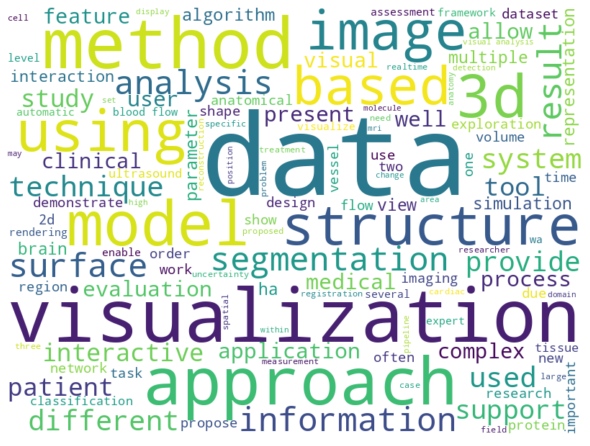

In [158]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text = flat_list
text = " ".join(text)

wordcloud = WordCloud(width=800, height=600,
                      background_color='white',
                      min_font_size=10,
                      max_words=200).generate(text)

# plot the WordCloud image
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)

plt.show()

In [124]:
# using spacy and scispacy

In [136]:

import spacy
import json

nlp = spacy.load("en_core_sci_sm")


def extract_entities_from_text():
    with open('../articles_data/all_articles_with_thumbnail_metadata.json') as f:
        papers = json.load(f)

    # To encode the papers, we must combine the title and the abstracts to a single string
    article_texts = [nlp(paper['article_title'].lower() + ' ' + paper['abstract'].lower()) for paper in
                     papers]
    article_titles = [nlp(paper['article_title']) for paper in papers]
    return article_texts


texts = []
articles_text = extract_entities_from_text()
for article in articles_text:
    texts.append([token.text for token in article if token.pos_ == 'NOUN'])
all_words = [item for sublist in texts for item in sublist]
len(all_words)



14659

In [142]:
unique_word_set = list(set(item for item in words if all_words.count(item) > 2))
len(unique_word_set)

689

In [144]:
import plotly.io as pio

doc_vectors = []
word_vecs = [np.array(model[word]).tolist() for word in unique_word_set if word in model.key_to_index]
model_words = [word for word in unique_word_set if word in model.key_to_index]
len(word_vecs)

umap_embeddings = UMAP(n_neighbors=5, n_components=2, metric='cosine', random_state=42)
low_dim_embeddings = umap_embeddings.fit_transform(word_vecs)
pio.renderers.default = "browser"
fig = px.scatter(low_dim_embeddings, x=0, y=1, opacity=1, hover_name=model_words)
fig.show()

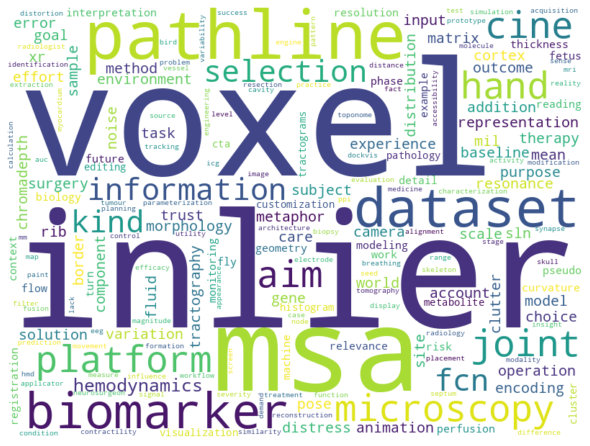

In [145]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text = unique_word_set
text = " ".join(text)

wordcloud = WordCloud(width=800, height=600,
                      background_color='white',
                      min_font_size=10,
                      max_words=200).generate(text)

# plot the WordCloud image
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)

plt.show()